<a href="https://colab.research.google.com/gist/HuynhDoTanThanh/fa2789704f3a9f4c2a7757e0eef67292/predict-final-score1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **BÀI TẬP COLAB SỐ 3:**
# **Predicting students' final exam scores from wecode data**



#Data preparation

In [1]:
# Import các thư viện cần thiết
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
%matplotlib inline

In [62]:
# Đọc 2 files wecode.csv và score_training.csv lần lượt vào 2 biến Input và Output
Input=pd.read_csv("https://docs.google.com/spreadsheets/d/14LHQD-iaezhk6twpunNqZT7JFVMo5llTEkHeHqi0qs8/export?format=csv")
Output=pd.read_csv("https://docs.google.com/spreadsheets/d/129CHMLdJCJKhtE7kVN2EWsaJ7Q9cLYKYmNHHKBUQEYs/export?format=csv")

In [ ]:
Input

,id,assignment_id,problem_id,user_id,is_final,status,pre_score,coefficient,file_name,language_id,created_at,updated_at
0,4,0,3,4,1,SCORE,10000,100,solution-0,2,2020-10-30 10:58:11,2020-10-30 10:58:19
1,5,0,4,4,1,SCORE,10000,100,solution-1,2,2020-10-30 11:07:09,2020-10-30 11:07:17
2,6,0,5,4,0,Compilation Error,0,100,solution-2,2,2020-10-30 11:08:01,2020-10-30 11:23:36
3,7,0,5,4,0,Compilation Error,0,100,solution-3,2,2020-10-30 11:11:41,2020-10-30 11:11:42
4,8,0,5,4,0,Compilation Error,0,100,solution-4,2,2020-10-30 11:15:06,2020-10-30 11:15:07
...,...,...,...,...,...,...,...,...,...,...,...,...
264601,266667,0,25,1796,0,SCORE,0,100,solution-3977,4,2021-04-28 9:34:20,2021-04-28 9:34:27
264602,266668,0,25,1796,0,Compilation Error,0,100,solution-3978,2,2021-04-28 9:35:07,2021-04-28 9:35:08
264603,266669,0,25,1796,1,SCORE,10000,100,solution-3979,4,2021-04-28 9:35:15,2021-04-28 9:35:21
264604,266670,0,150,255,1,SCORE,6250,100,solution-3980,2,2021-05-11 1:34:57,2021-05-11 1:35:28


In [ ]:
Output

,id,QT,GK,TH,CK,TBM,TBTL
0,22,10,9,8.5,8.5,8.8,8.52
1,24,10,8,10,9.5,9.4,8.41
2,27,10,10,10,10,10,8.67
3,28,10,9.5,7.5,9.5,9.2,7.39
4,29,10,9.5,5,8.5,8.2,8.05
...,...,...,...,...,...,...,...
970,1857,5,4.5,10,4,6,6.03
971,1859,8,5,10,1.5,5.4,5.06
972,1862,5,6.5,1,7.5,5.1,4.71
973,1865,6.5,,3,7.5,,6.89


#Data discovery

## wecode.csv

In [ ]:
#Thông tin về file wecode.csv
Input.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264606 entries, 0 to 264605
Data columns (total 12 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             264606 non-null  int64 
 1   assignment_id  264606 non-null  int64 
 2   problem_id     264606 non-null  int64 
 3   user_id        264606 non-null  int64 
 4   is_final       264606 non-null  int64 
 5   status         264605 non-null  object
 6   pre_score      264606 non-null  int64 
 7   coefficient    264606 non-null  object
 8   file_name      264606 non-null  object
 9   language_id    264606 non-null  int64 
 10  created_at     264606 non-null  object
 11  updated_at     264606 non-null  object
dtypes: int64(7), object(5)
memory usage: 24.2+ MB




> **Nhận xét:** Tất cả các cột trong file wecode.csv đều đầy đủ giá trị, không có cột nào chứa null values 



In [ ]:
# Đếm tổng số lượng submissions của mỗi user_id
# file user_info chứa thông tin thống kê được của mỗi user_id dựa trên file wecode.csv
user_info=Input[["user_id", "id"]].groupby("user_id").count() #Đếm số lượng id(cũng là số lượng submissions của mỗi user)
user_info=user_info.rename(columns = {"id":"id_count"}).reset_index() #Đổi tên cột id vừa đếm thành id_count

In [ ]:
# Đếm tổng số lượng asignments mà mỗi user_id tham gia
# Lọc ra cột user_id và assignment_id. Sau đó, drop những dòng trùng lặp nhau (giống nhau về cả user_id lẫn assignment_id)
assignment=Input[["user_id", "assignment_id"]].drop_duplicates() 
# Đếm số lượng asignment_id của mỗi user_id
assignment=assignment.groupby("user_id").count() 
assignment=assignment.rename(columns = {"assignment_id":"assignment_count"}).reset_index()
# Nối file user_id và thông tin về số assignment của mỗi sinh viên vừa tìm được ở trên
# (nối thẳng theo dòng tương ứng mà không cần join vì sau khi groupby user_id thì user_id đã được sort theo thứ tự)
user_info=pd.concat([user_info, assignment["assignment_count"]], axis=1) 

In [ ]:
# Đếm tổng số lượng problems mà mỗi user_id tham gia giống như cách đếm số assignements
problem=Input[["user_id", "problem_id"]].drop_duplicates()
problem=problem.groupby("user_id").count()
problem=problem.rename(columns = {"problem_id":"problem_count"}).reset_index()
user_info=pd.concat([user_info, problem["problem_count"]], axis=1) 

In [ ]:
# Tính điểm TB của mỗi user_id (= tổng pre_score của tất cả assignments của tất cả problems/ Tổng số assignements của tất cả problems )
# Lọc ra cột user_id, assignment_id, problem_id và pre_score
score=Input[["user_id", "assignment_id", "problem_id", "pre_score"]]
# Nhóm các user_id, assignment_id, problem_id rồi tính tổng điểm mỗi user
score=score.groupby(["user_id","assignment_id", "problem_id"]).sum().apply(lambda x: x)
# Nhóm các user_id rồi tính điểm TB của mỗi user_id (= tổng điểm chia cho tổng số problems của tất cả assignments mà mỗi user_id tham gia) 
score=score.groupby(["user_id"]).mean()
score=score.rename(columns = {"pre_score":"average_score"}).reset_index()
# Thêm thông tin về điểm TB vừa tính vào file user_info
user_info=pd.concat([user_info, score["average_score"]], axis=1)

In [ ]:
# Đếm số languages mà mỗi user_id sử dụng
language=Input[["user_id", "language_id"]].drop_duplicates()
language=language.groupby("user_id").count()
language=language.rename(columns = {"language_id":"language_count"}).reset_index()
user_info=pd.concat([user_info, language["language_count"]], axis=1)

In [ ]:
user_info

,user_id,id_count,assignment_count,problem_count,average_score,language_count
0,1,2,1,2,5000.000000,1
1,4,54,1,41,11365.853659,1
2,5,6,4,5,6000.000000,1
3,6,130,4,88,10849.853933,1
4,7,5,1,2,9421.500000,1
...,...,...,...,...,...,...
1154,1860,76,10,43,8446.666667,1
1155,1862,12,2,6,6666.666667,1
1156,1864,187,5,63,8941.142857,1
1157,1865,99,3,17,11144.705882,1


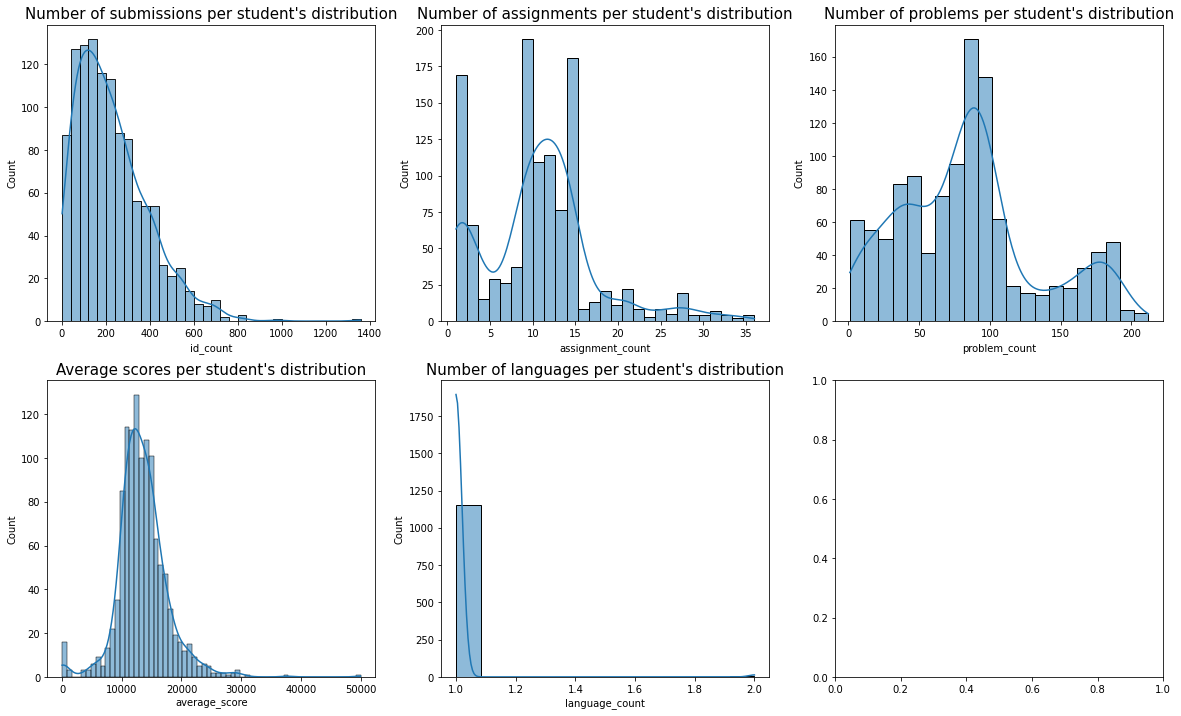

In [ ]:
cols=["id_count",	"assignment_count",	"problem_count",	"average_score",	"language_count"]
titles=["submissions","assignments","problems","Average scores", "languages"]
fig, axs = plt.subplots(2,3, figsize = (20,12))
n=0
for i in range(2):
  for j in range(3):
    if n!=5:
      if n!=3:
        axs[i,j].set_title("Number of "+titles[n]+" per student's distribution", size=15)
      else:
        axs[i,j].set_title(titles[n]+" per student's distribution", size=15)
      sns.histplot(user_info[cols[n]], kde=True, ax=axs[i,j])
      n+=1

> **Nhận xét:**
*   Số submissions của các sinh viên rơi vào khoảng 40-240 là nhiều nhất
*   Số assignments của các sinh viên rơi vào khoảng 10-15 là nhiều nhất
*   Số problems của các sinh viên rơi vào khoảng 90-110 là nhiều nhất
*   Điểm wecode trung bình của các sinh viên rơi vào khoảng 10000-15000 là nhiều
*  Phần lớn sinh viên IT001 chỉ sử dụng 1 ngôn ngữ, việc sử dụng 2 ngôn ngữ là rất ít và có vẻ như là submit nhầm ngôn ngữ 

##Công thức của Nhóm: 


In [ ]:
# Viết một vài hàm cần thiết
# Merge cột thông số đã tính với cột CK
def merge_dataframe(Output, score):
  # Đổi tên cột id của dataframe Output thành user_id.
  Output.rename(columns = {'id': 'user_id'}, inplace=True)
  # Merge 2 dataframe lại để có được hệ số quyết định trình độ của một sinh viên và cả điểm cuối kì của sinh viên đó.
  merge_result = score.merge(Output[['user_id', 'CK']], on = ['user_id'])
  # Xoá các hàng có điểm CK bằng null.
  merge_result = merge_result.drop(index = merge_result.loc[(merge_result['CK'].isnull()) | (merge_result['CK'] == '\xa0'), :].index)
  # Chuyển cột cuối kì thành kiểu float.
  merge_result['CK'] = merge_result['CK'].astype(float)
  return merge_result
# Vẽ biểu đồ
def scatter_plot(x, y, title):
  plt.figure(figsize=(8, 6))
  plt.scatter(x, y, color='green', s=20)
  plt.xlabel(x.name, fontsize=12)
  plt.ylabel('CK', fontsize=12)
  plt.title(title, fontsize=15)

###1. Tính tổng của (coefficient của bài nộp có final = 1 và pre_score = 10000) chia cho số lượng user hoàn thành của problem đó của mỗi problem trên mỗi assignment

In [ ]:
#Tính tổng số lượng user hoàn thành của mỗi problem trên mỗi assignment.
sum_user_done_problem = Input.loc[(Input['is_final'] == 1) & (Input['pre_score'] == 10000), ['user_id', 'problem_id', 'assignment_id']]\
                             .groupby(['assignment_id', 'problem_id'],  as_index=False)\
                             .count()
sum_user_done_problem.rename(columns = {'user_id': 'total_id'}, inplace = True)

#tính hệ số quyết định trình độ của một sinh viên dựa trên tổng của (coefficient của bài nộp có final = 1 và pre_score = 10000) chia cho số lượng user hoàn thành của problem đó của mỗi problem trên mỗi assignment

# merge hai bảng Input và sum_user_done_problem để có số lượng user hoàn thành của mỗi problem trên mỗi bài hoàn thành.
factor_score = Input.loc[(Input['is_final'] == 1) & (Input['pre_score'] == 10000), ['user_id', 'problem_id', 'assignment_id', 'coefficient']]\
             .merge(sum_user_done_problem, on = ['assignment_id', 'problem_id'])
#chuyển coefficient thành float và 'error' thành 0
factor_score['coefficient'] = factor_score['coefficient'].apply(lambda x: 0 if x == 'error' else float(x))
#tính điểm bằng coefficient chia cho tổng user hoàn thành problem đó
factor_score['Score'] = factor_score['coefficient']/factor_score['total_id']
#groupby user_id theo tổng của Score.
factor_score = factor_score[['user_id', 'Score']].groupby(['user_id'],  as_index=False).sum()
factor_score

,user_id,Score
0,1,100.000000
1,4,3017.619048
2,5,4.602470
3,6,7588.529015
4,11,702.380952
...,...,...
1134,1860,47.224781
1135,1862,7.616685
1136,1864,1906.308370
1137,1865,31.534100


In [ ]:
#merge 2 data score vaf Output để có thêm điểm cuối kì
merge_result = merge_dataframe(Output, factor_score)
merge_result

,user_id,Score,CK
0,24,1940.642423,9.5
1,27,67.916667,10.0
2,29,190.247036,8.5
3,34,241.277426,6.5
4,35,358.652031,4.5
...,...,...,...
837,1856,37.432022,7.5
838,1857,66.182954,4.0
839,1859,10.594406,1.5
840,1862,7.616685,7.5


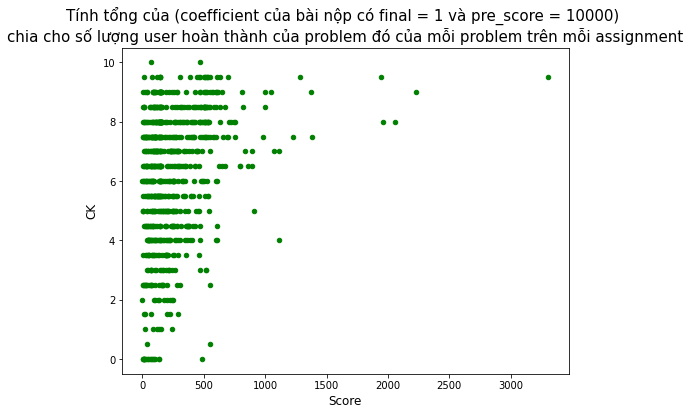

In [ ]:
# Vẽ biểu đồ
scatter_plot(merge_result['Score'], merge_result['CK'], 'Tính tổng của (coefficient của bài nộp có final = 1 và pre_score = 10000) \nchia cho số lượng user hoàn thành của problem đó của mỗi problem trên mỗi assignment')



> **Nhận xét**: Tổng của (coefficient của bài nộp có final = 1 và pre_score = 10000)/ số lượng user hoàn thành của problem đó của mỗi problem trên mỗi assignment có xu hướng tăng dần theo điểm cuối kì



### 2. Tổng max pre_score của tất cả problems trong tất cả assignments/ Tổng số problems của tất cả assignments mà mỗi user_id tham gia

In [ ]:
# Lọc ra cột user_id, assignment_id, problem_id và pre_score
average_score=Input[["user_id", "assignment_id", "problem_id", "pre_score"]]
# Nhóm các user_id, assignment_id, problem_id rồi chọn ra max prescore
average_score=average_score.groupby(["user_id","assignment_id", "problem_id"]).max()
# Nhóm các user_id rồi tính TB max pre_score(= Tổng max pre_score của tất cả problems trong tất cả assignments/ Tổng số problems của tất cả assignments) 
average_score=average_score.groupby(["user_id"]).mean()
average_score=average_score.rename(columns = {"pre_score":"average_score"}).reset_index()
average_score

,user_id,average_score
0,1,5000.000000
1,4,9756.097561
2,5,6000.000000
3,6,9662.921348
4,7,4604.500000
...,...,...
1154,1860,6868.020833
1155,1862,6666.666667
1156,1864,6980.015873
1157,1865,6848.705882


In [ ]:
merge_result = merge_dataframe(Output, average_score)
merge_result

,user_id,average_score,CK
0,24,9747.423077,9.5
1,27,7800.000000,10.0
2,29,9534.500000,8.5
3,34,9796.285714,6.5
4,35,9782.894737,4.5
...,...,...,...
848,1856,8735.161290,7.5
849,1857,9650.000000,4.0
850,1859,1300.000000,1.5
851,1862,6666.666667,7.5


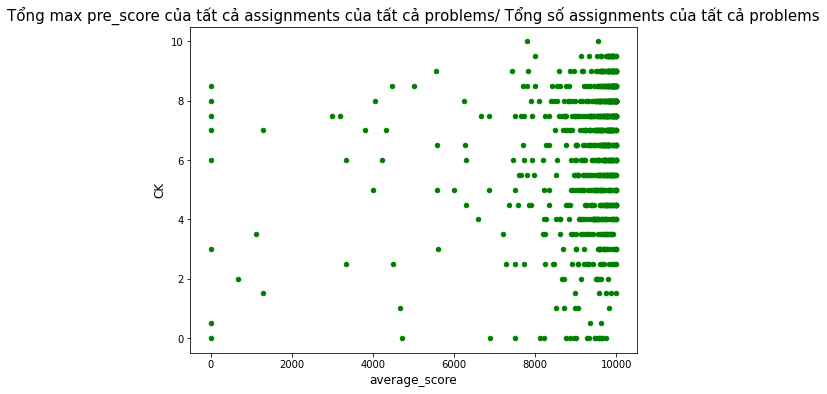

In [ ]:
# Vẽ biểu đồ
scatter_plot(merge_result['average_score'], merge_result['CK'], 'Tổng max pre_score của tất cả assignments của tất cả problems/ Tổng số assignments của tất cả problems')



> **Nhận xét**:
- Điểm trung bình của tất cả problems của tất cả assignments mà các sinh viên tham phần lớn đều đạt từ 9000 đến 10000
- Hầu hết sinh viên có điểm cuối kì từ 4 đến 10 đều đạt điểm trung bình từ 9000 đến 10000



##Công thức nhóm 1: 
###Tổng số problem đã solved (is_final = 1 && pre_score=10000) / Tổng số problem có submit

In [ ]:
# Tổng số problem đã solved (is_final = 1 && pre_score=10000)
total_problem_solved = Input.loc[(Input['is_final'] == 1) & (Input['pre_score'] == 10000), ['user_id', 'problem_id']]\
                            .groupby('user_id', as_index = False)\
                            .count()
# Tổng số problem có submit
Drop_duplicate = Input[['user_id', 'assignment_id', 'problem_id']].drop_duplicates()
total_problem_submit = Drop_duplicate[['user_id', 'problem_id']]\
                            .groupby('user_id', as_index = False)\
                            .count()
# merge 2 data lại
factor_score = total_problem_solved.merge(total_problem_submit, on = 'user_id')
# Thêm columns Score bằng tổng số problem đã solved (is_final = 1 && pre_score=10000) / tổng số problem có submit
factor_score['Solved problem rate'] = factor_score['problem_id_x']/factor_score['problem_id_y']
# Xoá 2 cột problem_id nảy merge dư
factor_score.drop(columns=['problem_id_x', 'problem_id_y'], inplace=True)
factor_score

,user_id,Solved problem rate
0,1,0.500000
1,4,0.902439
2,5,0.600000
3,6,0.955056
4,11,0.473684
...,...,...
1134,1860,0.583333
1135,1862,0.666667
1136,1864,0.444444
1137,1865,0.588235


In [ ]:
# merge 2 data score và Output để có thêm điểm cuối kì
merge_result= merge_dataframe(Output, factor_score)
merge_result

,user_id,Solved problem rate,CK
0,24,0.923077,9.5
1,27,0.600000,10.0
2,29,0.900000,8.5
3,34,0.964286,6.5
4,35,0.953947,4.5
...,...,...,...
837,1856,0.741935,7.5
838,1857,0.925000,4.0
839,1859,0.100000,1.5
840,1862,0.666667,7.5


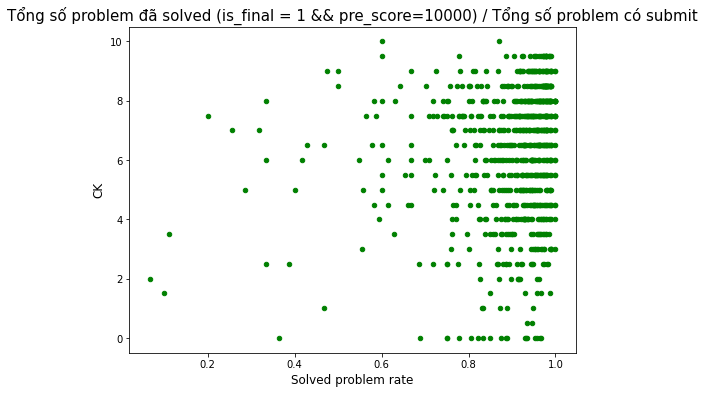

In [ ]:
# Vẽ biểu đồ
scatter_plot(merge_result['Solved problem rate'], merge_result['CK'], 'Tổng số problem đã solved (is_final = 1 && pre_score=10000) / Tổng số problem có submit')

> **Nhận xét:** Tỉ lệ submit problem của sinh viên có điểm cuối kì từ 5 trở lên lớn hơn của sinh viên có điểm cuối kì dưới 5





##Công thức nhóm 2: 
###Tổng số problem đã submit / Tổng số submissions

In [ ]:
# Tổng số problem đã submit
Drop_duplicate = Input[['user_id', 'assignment_id', 'problem_id']].drop_duplicates()
total_problem_apply = Drop_duplicate[['user_id', 'problem_id']]\
                            .groupby('user_id', as_index = False)\
                            .count()
# Tổng số submissions
total_problem_submissions = Input[['user_id', 'id']]\
                            .groupby('user_id', as_index = False)\
                            .count()
# merge 2 data lại
factor_score = total_problem_apply.merge(total_problem_submissions, on = 'user_id')
# Thêm columns Score bằng Tổng số problem đã sumbit / Tổng số submissions
factor_score['Problem submission rate'] = factor_score['problem_id']/factor_score['id']
# Xoá 2 cột nảy merge dư
factor_score.drop(columns=['problem_id', 'id'], inplace=True)
factor_score

,user_id,Problem submission rate
0,1,1.000000
1,4,0.759259
2,5,0.833333
3,6,0.684615
4,7,0.400000
...,...,...
1154,1860,0.631579
1155,1862,0.500000
1156,1864,0.336898
1157,1865,0.171717


In [ ]:
# merge 2 data score vaf Output để có thêm điểm cuối kì
merge_result = merge_dataframe(Output, factor_score)
merge_result

,user_id,Problem submission rate,CK
0,24,0.475610,9.5
1,27,0.384615,10.0
2,29,0.402010,8.5
3,34,0.385321,6.5
4,35,0.511785,4.5
...,...,...,...
848,1856,0.484375,7.5
849,1857,0.727273,4.0
850,1859,0.967742,1.5
851,1862,0.500000,7.5


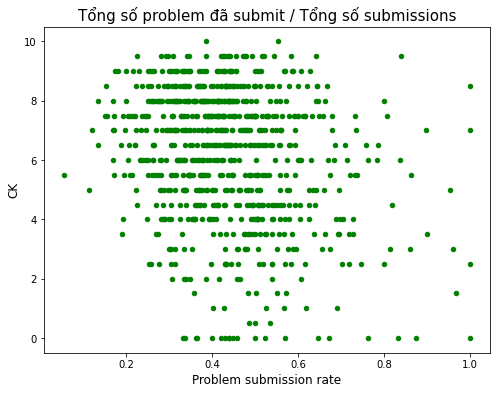

In [ ]:
# Vẽ biểu đồ
scatter_plot(merge_result['Problem submission rate'], merge_result['CK'], 'Tổng số problem đã submit / Tổng số submissions')

> **Nhận xét:** 
- Tổng số problem đã submit / Tổng số submissions của các sinh viên chủ yếu từ 0.2 đến 0.7
- Tổng số problem đã submit / Tổng số submissions của các sinh viên có điểm CK từ 5 trở lên lớn hơn của sinh viên có điểm CK nhỏ hơn 5



##Công thức nhóm 3: 
###Số lần submit đúng (pre_score=10000) / tổng số submissions 

In [ ]:
#Số lần submit đúng (pre_score=10000)
total_problem_correct = Input.loc[(Input['pre_score'] == 10000), ['user_id', 'pre_score']]\
                            .groupby('user_id', as_index = False)\
                            .count()
#Tổng số submissions
total_problem_submissions = Input[['user_id', 'id']]\
                            .groupby('user_id', as_index = False)\
                            .count()
#merge 2 data lại
factor_score = total_problem_correct.merge(total_problem_submissions, on = 'user_id')
#Thêm columns Score bằng Tổng số problem đã sumbit / Tổng số submissions
factor_score['Correct submission rate'] = factor_score['pre_score']/factor_score['id']
#Xoá 2 cột nảy merge dư
factor_score.drop(columns=['pre_score', 'id'], inplace=True)
factor_score

,user_id,Correct submission rate
0,1,0.500000
1,4,0.814815
2,5,0.500000
3,6,0.684615
4,11,0.380000
...,...,...
1134,1860,0.381579
1135,1862,0.333333
1136,1864,0.160428
1137,1865,0.101010


In [ ]:
#merge 2 data score vaf Output để có thêm điểm cuối kì
merge_result = merge_dataframe(Output, factor_score)
merge_result

,user_id,Correct submission rate,CK
0,24,0.487805,9.5
1,27,0.307692,10.0
2,29,0.376884,8.5
3,34,0.371560,6.5
4,35,0.511785,4.5
...,...,...,...
837,1856,0.359375,7.5
838,1857,0.672727,4.0
839,1859,0.096774,1.5
840,1862,0.333333,7.5


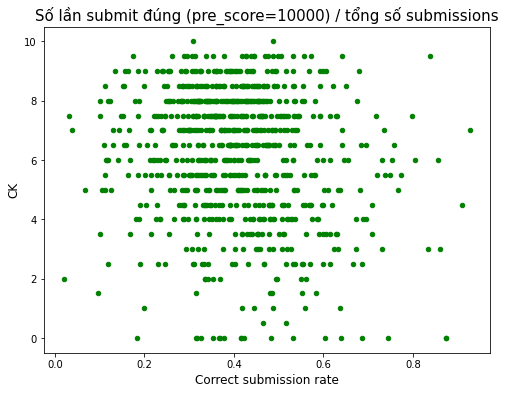

In [ ]:
# Vẽ biểu đồ'
scatter_plot(merge_result['Correct submission rate'], merge_result['CK'], 'Số lần submit đúng (pre_score=10000) / tổng số submissions')



> **Nhận xét:** 
- Tỉ lệ submt đúng của các sinh viên chủ yếu từ 0.2 đến 0.7
- Tỉ lệ submt đúng của các sinh viên có điểm CK từ 5 trở lên lớn hơn của sinh viên có điểm CK nhỏ hơn 5



##Công thức nhóm 4: 
###Tổng pre_score của các submssion có is_final = 1

In [ ]:
#Tổng số problem đã solved (is_final = 1 && pre_score=10000)
total_pre_score = Input.loc[(Input['is_final'] == 1), ['user_id', 'pre_score']]\
                            .groupby('user_id', as_index = False)\
                            .sum()
total_pre_score.rename(columns={'pre_score': 'Total score'}, inplace=True)
total_pre_score

,user_id,Total score
0,1,10000
1,4,370000
2,5,30000
3,6,850000
4,7,9209
...,...,...
1152,1860,329665
1153,1862,40000
1154,1864,439741
1155,1865,116428


In [ ]:
#merge 2 data score và Output để có thêm điểm cuối kì
merge_result = merge_dataframe(Output, total_pre_score)
merge_result

,user_id,Total score,CK
0,24,750299,9.5
1,27,39000,10.0
2,29,762760,8.5
3,34,822888,6.5
4,35,1477000,4.5
...,...,...,...
847,1856,270790,7.5
848,1857,386000,4.0
849,1859,39000,1.5
850,1862,40000,7.5


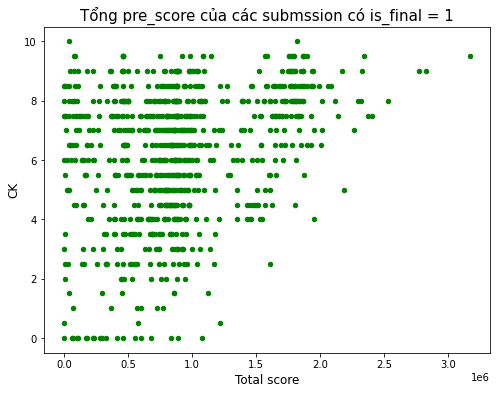

In [ ]:
# Vẽ biểu đồ'
scatter_plot(merge_result['Total score'], merge_result['CK'], 'Tổng pre_score của các submssion có is_final = 1')



> **Nhận xét:** Tổng prescore có final = 1 có xu hướng tăng dần theo điểm cuối kì



##Công thức nhóm 5: 
###Trung bình cộng của Tỷ lệ: problem đã submit/số lượng problem của mỗi assignments 

In [ ]:
#Tính tổng số problem trong mỗi assigment
p=Input[['assignment_id', 'problem_id']]
sl_prob=p.groupby('assignment_id').nunique()
x=Input[['user_id','assignment_id','problem_id']]
sl_submit=x.groupby(['user_id','assignment_id']).nunique()
assign_uni=Input['assignment_id'].unique()
assign_uni.sort()
s1=pd.Series(assign_uni,name='assignment_id')
s2=pd.Series(np.array(sl_prob['problem_id']),name='problem_id')
sl_prob2=pd.concat([s1,s2],axis=1)
sl_prob2

,assignment_id,problem_id
0,0,352
1,5,4
2,7,10
3,8,8
4,10,7
...,...,...
285,376,10
286,377,7
287,381,4
288,383,47


In [ ]:
#Tính tổng số problem trong mỗi assigment 
p=Input[['assignment_id', 'problem_id']]
sl_prob=p.groupby('assignment_id').nunique()
sl_prob=sl_prob.reset_index()
x=Input[['user_id','assignment_id','problem_id']]
sl_submit=x.groupby(['user_id','assignment_id']).nunique()
sl_submit=sl_submit.reset_index()
sl_prob.columns=['assignment_id','total_problem']
sl_submit.columns=['user_id','assignment_id','problem_submited']
a=pd.merge(sl_prob,sl_submit,how='left',on=['assignment_id'])

In [ ]:
#Tính phần trăm mà user làm được trong mỗi assignment
percent=pd.Series(a['problem_submited']/a['total_problem'], name='percent_in_assignment')
b=pd.concat([a,percent],axis=1)
c=b.groupby('user_id').mean()
c=c.reset_index()
c=c[['user_id','percent_in_assignment']]
c.columns=['user_id','mean_percent_all_assignment']
c

,user_id,mean_percent_all_assignment
0,1,0.005682
1,4,0.116477
2,5,0.114394
3,6,0.306203
4,7,0.005682
...,...,...
1154,1860,0.615000
1155,1862,0.450000
1156,1864,0.690000
1157,1865,0.588889


In [ ]:
merge_result=merge_dataframe(Output, c)
merge_result

,user_id,mean_percent_all_assignment,CK
0,24,0.663333,9.5
1,27,0.223643,10.0
2,29,0.807911,8.5
3,34,0.854545,6.5
4,35,0.901952,4.5
...,...,...,...
848,1856,0.710000,7.5
849,1857,0.891667,4.0
850,1859,0.557143,1.5
851,1862,0.450000,7.5


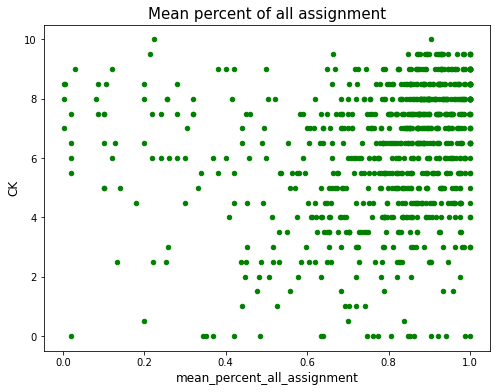

In [ ]:
#Vẽ scatter plot
scatter_plot(merge_result['mean_percent_all_assignment'], merge_result['CK'], 'Mean percent of all assignment')

> **Nhận xét:**
* Theo đồ thị thì sinh viên đa số đạt điểm từ: 4 - 9. Trong đó trung bình số phần trăm làm bài đa số trong khoảng: 60%-100%, dưới 60% rải rác 
* Số sinh viên làm nhiều bài nhưng có điểm thấp có thể là do tỷ lệ làm đúng thấp.


##Công thức nhóm 6: 
###Tổng của (max pre_score của mỗi problem_id)

In [ ]:
# Lọc ra 'user_id', 'problem_id','pre_score'
total_score=Input[['user_id', 'problem_id','pre_score']]
# Chọn ra max prescore của mỗi problem và tính tổng
total_score=total_score.groupby(['user_id', 'problem_id'], as_index=False).max()
total_score=total_score[['user_id','pre_score']].groupby('user_id', as_index=False).sum()
total_score.rename(columns={"pre_score":"Total max score per problem"}, inplace=True)
total_score

,user_id,Total max score per problem
0,1,10000
1,4,400000
2,5,30000
3,6,850000
4,7,9209
...,...,...
1154,1860,300221
1155,1862,40000
1156,1864,439741
1157,1865,116428


In [ ]:
# merge 2 data lại
merge_result = merge_dataframe(Output, total_score)
merge_result

,user_id,Total max score per problem,CK
0,24,760299,9.5
1,27,39000,10.0
2,29,762760,8.5
3,34,822888,6.5
4,35,1437000,4.5
...,...,...,...
848,1856,270790,7.5
849,1857,337000,4.0
850,1859,39000,1.5
851,1862,40000,7.5


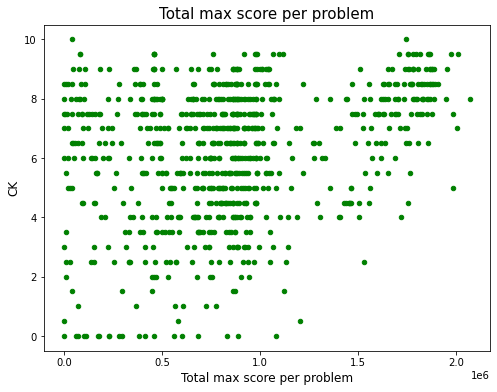

In [ ]:
# Vẽ biểu đồ
scatter_plot(merge_result['Total max score per problem'], merge_result['CK'], 'Total max score per problem')



> **Nhận xét**: Tổng max prescore của mỗi problem chủ yếu từ 0 đến 1 triệu và có xu hướng tăng dần theo điểm CK



##Công thức nhóm 7: 
###Trung bình cộng (thời điểm submit cuối cùng - thời điểm submit đầu tiên của mỗi problem)

In [ ]:
from datetime import datetime
# Xử lý thời gian kiểu chuỗi sang kiểu datetime
Input['created_at']=Input['created_at'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
Input['updated_at']=Input['updated_at'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))

In [ ]:
# Lọc ra thời gian submit nhỏ nhất và lớn nhất của mỗi problem
time=Input[['user_id','problem_id','created_at']]
earliest_time=time.groupby(['user_id','problem_id'], as_index=False).min()
time=Input[['user_id','problem_id','updated_at']]
latest_time=time.groupby(['user_id','problem_id'], as_index=False).max()
# Tính hiệu thời gian = thời gian lớn nhất - thời gian nhỏ nhất rồi chuyển qua giây đe
time_difference=earliest_time.merge(latest_time, on=['user_id','problem_id'])
time_difference['time']=(latest_time['updated_at']-earliest_time['created_at']).dt.total_seconds()
time_difference.dropna(inplace=True)
# Tính trung bình tổng của các hiệu thời gian trên
average_time=time_difference[['user_id','time']]
average_time=average_time.groupby(['user_id'],as_index=False).mean()
average_time.rename(columns={'time':'average_time'},inplace=True)
average_time

,user_id,average_time
0,1,6.500000
1,4,148.926829
2,5,492.600000
3,6,6356.670455
4,7,1162.000000
...,...,...
1154,1860,145163.488372
1155,1862,458.000000
1156,1864,17946.222222
1157,1865,46922.941176


In [ ]:
# merge 2 data
merge_result=merge_dataframe(Output,average_time)
merge_result

,user_id,average_time,CK
0,24,47079.641026,9.5
1,27,1100.800000,10.0
2,29,47853.187500,8.5
3,34,46997.107143,6.5
4,35,107550.027211,4.5
...,...,...,...
848,1856,63377.193548,7.5
849,1857,206008.441176,4.0
850,1859,190674.777778,1.5
851,1862,458.000000,7.5


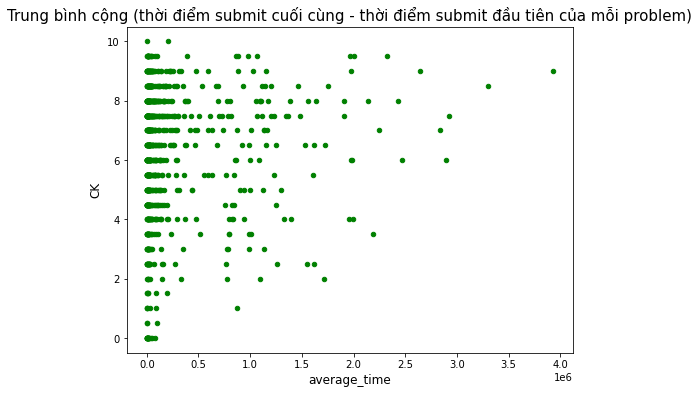

In [ ]:
# Vẽ biểu đồ
scatter_plot(merge_result['average_time'], merge_result['CK'], 'Trung bình cộng (thời điểm submit cuối cùng - thời điểm submit đầu tiên của mỗi problem)')





> **Nhận xét:**
- Trung bình cộng thời gian submit của mỗi problem ở các sinh viên có điểm CK từ 5 trở lên cao hơn so với sinh viên có điểm CK nhỏ hơn 5
- Trung bình cộng thời gian submit của mỗi problem có xu hướng tăng dần theo điểm CK. Có vẻ các bạn có điểm càng cao sẽ dành nhiều thời gian cho mỗi problem hơn thay vì đi nộp lại bài đã được bạn khác làm



## score_training.csv

In [ ]:
Output.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 975 entries, 0 to 974
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  975 non-null    int64 
 1   QT       973 non-null    object
 2   GK       974 non-null    object
 3   TH       974 non-null    object
 4   CK       974 non-null    object
 5   TBM      974 non-null    object
 6   TBTL     974 non-null    object
dtypes: int64(1), object(6)
memory usage: 53.4+ KB




> **Nhận xét:** Các cột trong file score_training.csv không đầy đủ giá trị. Các cột điểm đều có kiểu dữ liệu string chứ không phải float.



In [53]:
Final_score = Output.copy()

cols=["QT",	"GK",	"TH",	"CK",	"TBM",	"TBTL"]
for col in cols:
  Final_score[col]=pd.to_numeric(Final_score[col],errors='coerce') # Chuyển từng cột điểm qua kiểu numeric 


In [54]:
Final_score=Final_score.dropna().rename(columns={"id":"user_id"}) # Xóa những hàng có giá trị null
Final_score

,user_id,QT,GK,TH,CK,TBM,TBTL
0,22,10.0,9.0,8.5,8.5,8.8,8.52
1,24,10.0,8.0,10.0,9.5,9.4,8.41
2,27,10.0,10.0,10.0,10.0,10.0,8.67
3,28,10.0,9.5,7.5,9.5,9.2,7.39
4,29,10.0,9.5,5.0,8.5,8.2,8.05
...,...,...,...,...,...,...,...
969,1856,5.0,5.5,7.0,7.5,6.7,7.34
970,1857,5.0,4.5,10.0,4.0,6.0,6.03
971,1859,8.0,5.0,10.0,1.5,5.4,5.06
972,1862,5.0,6.5,1.0,7.5,5.1,4.71


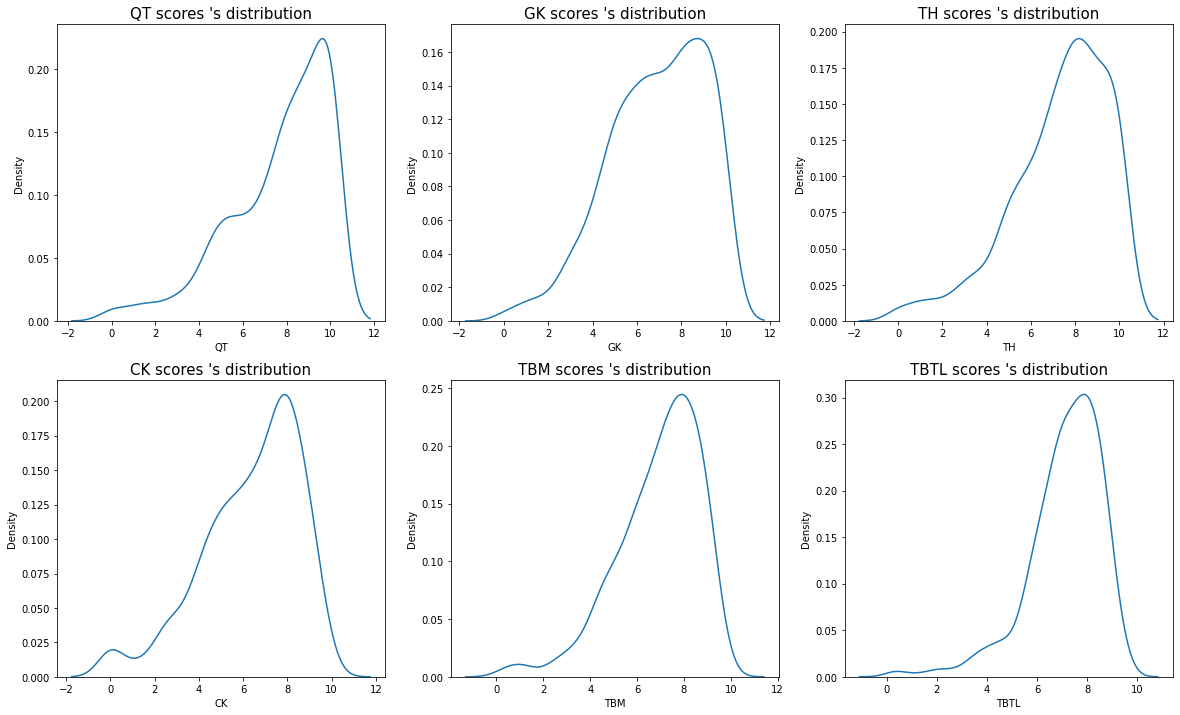

In [55]:
cols=["id",	"QT",	"GK",	"TH",	"CK",	"TBM",	"TBTL"]
fig, axs = plt.subplots(2,3, figsize = (20,12))
n=1
for i in range(2):
  for j in range(3):
      axs[i,j].set_title(cols[n]+" scores 's distribution", size=15)
      sns.kdeplot(Final_score[cols[n]], ax=axs[i,j])
      n+=1



> **Nhận xét:** 
- Điểm QT, GK và TH của các sinh viên rơi vào khoảng 8-10 là nhiều nhất. Còn điểm CK của các sinh viên thường chỉ rơi vào 8.
- Chính vì vậy, điểm TB môn của các sinh viên rơi vào 8 điểm là nhiều nhất do bị điểm CK kéo xuống.




# Predict final score

In [3]:
# import các models dành cho regresion, các thư viên và các hàm cần thiết
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy
import math

In [78]:
# Trích ra các thông số quan trọng từ file wecode.csv
def extract(Input):
  # Số lượng submissions, problems, asignments
  submission_count = Input[['user_id', 'id']].groupby(['user_id'], as_index = False).count()
  submission_count.rename(columns = {"id":"Number of submissions"}, inplace=True)

  problem_count = Input[['user_id', 'problem_id']].drop_duplicates().groupby(['user_id'], as_index = False).count()
  problem_count.rename(columns = {"problem_id":"Number of problems"}, inplace=True) 

  assignment_count = Input[['user_id', 'assignment_id']].drop_duplicates().groupby(['user_id'], as_index = False).count()
  assignment_count.rename(columns = {"assignment_id":"Number of assignments"}, inplace=True)

  # Tổng pre_score
  total_score=Input[['user_id', 'pre_score']].groupby("user_id", as_index = False).sum()
  total_score.rename(columns={'pre_score': 'Total score'}, inplace=True)

  # Tổng pre_score có is_final = 1
  total_final_score = Input.loc[(Input['is_final'] == 1), ['user_id', 'pre_score']]\
                            .groupby('user_id', as_index = False)\
                            .sum()
  total_final_score.rename(columns={'pre_score': 'Total final score'}, inplace=True)

  # Tổng max pre_score của mỗi problem_id
  total_max_score = Input[['user_id', 'problem_id','pre_score']].groupby(['user_id', 'problem_id'], as_index=False).max()
  total_max_score = total_max_score[['user_id','pre_score']].groupby('user_id', as_index=False).sum()
  total_max_score.rename(columns = {"pre_score":"Total max score per problem"}, inplace=True)

  return [submission_count, problem_count, assignment_count, total_score, total_final_score, total_max_score]

# merge các thông số và điểm CK theo user_id
def merge(features, Output):
  Final_score = Output.copy()
  Final_score['CK']=pd.to_numeric(Final_score['CK'],errors='coerce')
  Final_score.rename(columns={"id":"user_id"}, inplace=True)
  
  training_data=features[0]
  for feature in features[1:]:
    training_data=training_data.merge(feature, on='user_id')
  
  training_data=training_data.merge(Final_score[["user_id","CK"]], on='user_id')

  training_data = training_data.drop(index = training_data.loc[(training_data['CK'].isnull()) | (training_data['CK'] == '\xa0'), :].index)
  #training_data['CK'] = training_data['CK'].astype(float)
  return training_data

# xuất mean squared error và độ lỗi
def evaluate(y_test, y_pred):
  mse = mean_squared_error(y_test, y_pred)
  error = math.sqrt(mse)/np.average(y_test)
  print("MSE:", mse)
  print("Error", error*100,"(%)")

## Creating and preprocessing training data

In [79]:
# Tạo training data bằng cách trích ra các thông số quan trọng và merge với điểm CK theo user_id
features=extract(Input)
training_data=merge(features, Output)
training_data

,user_id,Number of submissions,Number of problems,Number of assignments,Total score,Total final score,Total max score per problem,CK
0,24,164,78,15,1031674,750299,760299,9.5
1,27,13,5,2,52000,39000,39000,10.0
2,29,199,80,13,1225828,762760,762760,8.5
3,34,218,84,11,1206981,822888,822888,6.5
4,35,297,147,25,1809718,1477000,1437000,4.5
...,...,...,...,...,...,...,...,...
847,1856,64,31,5,329074,270790,270790,7.5
848,1857,55,34,6,389000,386000,337000,4.0
849,1859,31,27,7,39000,39000,39000,1.5
850,1862,12,6,2,40000,40000,40000,7.5


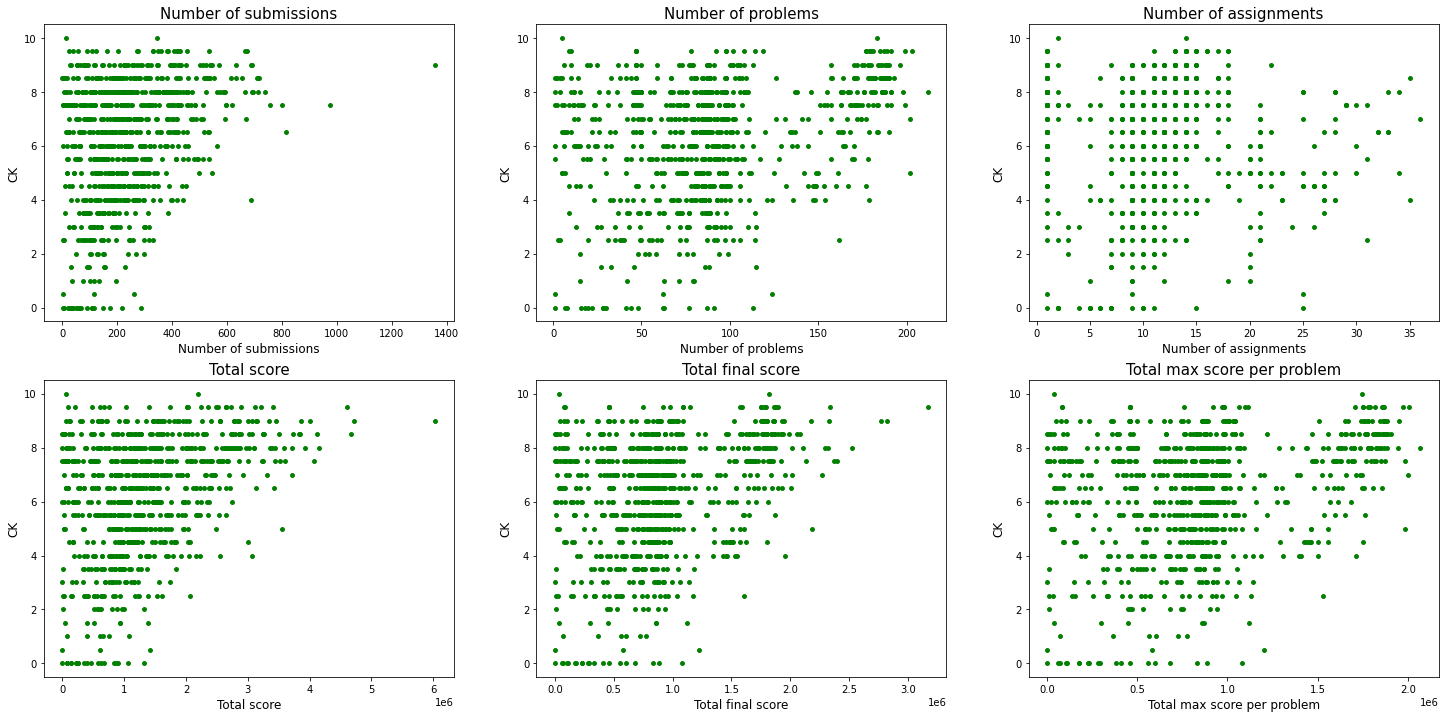

In [34]:
cols=["Number of submissions", "Number of problems", "Number of assignments", "Total score", "Total final score", "Total max score per problem"]
fig, ax = plt.subplots(2,3, figsize = (25, 12))
n=0
for i in range(2):
  for j in range(3):
    ax[i][j].set_title(cols[n], size=15)
    ax[i][j].set_xlabel(cols[n], size=12)
    ax[i][j].set_ylabel("CK", size=12)
    ax[i][j].scatter(training_data[cols[n]], training_data["CK"], s=15, c="g")
    n+=1



> **Nhận xét:** Nhóm chúng em chọn các thông số trên vì chúng thay đổi theo điểm CK rõ hơn các thông số khác. Cụ thể là khi điểm CK tăng, giá trị của các thông số trên cũng có xu hướng tăng theo.




In [41]:
# Chuẩn hóa các thông số bằng Standard Scaler trong thư viện sklearn
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
X=training_data.drop(columns=["CK", "user_id"], axis=1)
X=scaler.fit_transform(X)
y=training_data["CK"]

## Training with different models

### Linear Regression

In [42]:
# Chia train, test data theo tỉ lệ 7:3
X_train, X_test, y_train, y_test=train_test_split(X, y, train_size=0.7, test_size=0.3, random_state=1)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(563, 6) (563,)
(242, 6) (242,)


In [11]:
# Linear Regression
reg=LinearRegression().fit(X_train, y_train)
y_pred=reg.predict(X_test)
evaluate(y_test, y_pred)

MSE: 4.173657074028676
Error 34.28534207637382 (%)


> **Nhận xét:** Linear Regression với MSE và độ lỗi như trên chưa được tốt vì điểm CK dự đoán có thể sai lệch đến hơn 2 điểm so với điểm CK thực tế (vì MSE = 4.27... lấy căn sẽ lớn hơn 2)

In [12]:
# Ridge
reg=Ridge(alpha=0.001).fit(X_train, y_train)
y_pred=reg.predict(X_test)
evaluate(y_test, y_pred)

MSE: 4.173666842380179
Error 34.28538219839043 (%)


In [13]:
# Lasso
reg=Lasso(alpha=0.0025).fit(X_train, y_train)
y_pred=reg.predict(X_test)
evaluate(y_test, y_pred)

MSE: 4.186511032126108
Error 34.33809719582916 (%)


> **Nhận xét:** Nhóm chúng em đã sử dụng thêm Ridge và Lasso Regression để giảm overfitting nhưng kết quả cũng không tốt hơn. MSE và độ lỗi chưa được tốt nhiều khả năng không phải do overfitting vì những thông số được chọn không tăng tuyến tính quá rõ rệt theo điểm CK.

### Other Models

In [14]:
# K Neighbors Regressor
reg=KNeighborsRegressor(n_neighbors=25).fit(X_train, y_train)
y_pred=reg.predict(X_test)
evaluate(y_test, y_pred)

MSE: 4.129900826446281
Error 34.10514631253772 (%)


In [15]:
# Decision Tree Regressor
reg=DecisionTreeRegressor(max_depth=4).fit(X_train, y_train)
y_pred=reg.predict(X_test)
evaluate(y_test, y_pred)

MSE: 4.076287671181455
Error 33.88305168764466 (%)


In [16]:
# Random Forest Regressor
reg=RandomForestRegressor(max_depth=5).fit(X_train, y_train)
y_pred=reg.predict(X_test)
evaluate(y_test, y_pred)

MSE: 3.7921675147916885
Error 32.68088903676853 (%)


In [48]:
# Gradient Boosting Regressor
reg=GradientBoostingRegressor(learning_rate=0.05).fit(X_train, y_train)
y_pred=reg.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
evaluate(y_test, y_pred)

MSE: 3.6963470749917406
Error 32.26535718788628 (%)


#Dự đoán điểm còn thiếu


In [49]:
reg=GradientBoostingRegressor(learning_rate=0.05).fit(X, y)

In [97]:
def merge_to_pre_data(features, Output):
  Pre_data = Output.loc[(Output['CK'].isnull()) | (Output['CK'] == '\xa0'), ['id', 'CK']]
  Pre_data = Pre_data.rename(columns={'id': 'user_id'})

  training_data=features[0]
  for feature in features[1:]:
    training_data=training_data.merge(feature, on='user_id')

  training_data=training_data.merge(Pre_data, on='user_id')
  training_data.drop(columns='CK', inplace=True)

  return training_data

In [116]:
Pre_data = merge_to_pre_data(features, Output)

In [117]:
X = scaler.transform(Pre_data.drop(columns='user_id'))
Pre_data['CK'] = reg.predict(X)
Pre_data

,user_id,Number of submissions,Number of problems,Number of assignments,Total score,Total final score,Total max score per problem,CK
0,51,86,39,5,446194,380000,380000,3.933426
1,240,623,123,15,3066214,1309761,1174491,7.532640
2,391,379,111,14,2085960,1059240,1049240,7.189470
3,513,672,135,15,3222566,1319307,1275488,7.532640
4,586,296,124,15,2113473,1238947,1208947,7.002881
5,705,328,114,14,1859632,1180000,1140000,6.659727
6,772,292,91,13,1657940,1200552,903776,6.752036
7,774,197,99,14,1365874,988888,988888,6.145948
8,776,264,98,14,1338650,998888,978888,5.906787
9,792,422,102,15,2861806,1602776,1013888,7.743974


> **Nhận xét:** 
- Nhóm chúng em đã sử dụng thêm vài model khác để train và đều cho kết quả tốt hơn Linear Regression, trong đó Gradient Boosting Regressor là tốt nhất. MSE đã giảm xuống dưới 4 và độ lỗi còn khoảng 32% (dưới 1/3)
- MSE và độ lỗi như vậy có cải thiện hơn so với Linear Regression nhưng vẫn còn cao. Cụ thể, điểm CK dự đoán được có thể chênh lệch 1,9 điểm và sai lệch 32% so với điểm thực tế trung bình.

**Kết luận:**
- Nhóm chúng em nghĩ rằng điểm CK dự đoán sai lệch tối đa 0,5 điểm so với điểm CK thực tế (tức MSE <= 0,25) thì mới có thể đánh giá mô hình là tốt. Như vậy, với kết quả như trên, nhóm chúng em tự đánh giá mô hình của nhóm là chưa tốt và cần phải cải thiện hơn.
- Nhóm chúng em cho rằng cần phải có thêm nhiều training data, trích được nhiều các thông số có ý nghĩa hơn, kết hợp với lựa chọn các siêu tham số phù hợp hơn với mô hình thì MSE và độ lỗi mới có thể được cải thiện.